# **Project 1: House Price Prediction**

##**1.Collecting Data**

In [82]:
from bs4 import BeautifulSoup
import pandas as pd
import requests
import re
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')

In [ ]:
import requests
import time
import pandas as pd
from bs4 import BeautifulSoup

def get_last_page(doc):
    """Extract the last page number from pagination"""
    pagination = doc.find('div', class_='paging')
    if pagination:
        # Giả sử số trang cuối nằm ở phần tử li kế cuối
        last_page_link = pagination.find_all('li')[-2].find('a')
        if last_page_link:
            return int(last_page_link.text.strip())
    return 1

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

url = "https://batdongsan.vn/ban-nha-ho-chi-minh"
result = requests.get(url, headers=headers)
doc = BeautifulSoup(result.text, 'html.parser')

last_page = get_last_page(doc)
print(f"Total pages to scrape: {last_page}")

attribute = ["Name", "Price", "District", "Acreage", "Num_bedroom", "Num_WC", "Address", "Description", "Link"]
df = pd.DataFrame(columns=attribute)

for page in range(1, last_page + 1):
    url_page = f"https://batdongsan.vn/ban-nha-ho-chi-minh/p{page}"
    print(f"Scraping page {page}/{last_page}")
    
    result = requests.get(url_page, headers=headers)
    doc = BeautifulSoup(result.text, 'html.parser')
    
    # Sử dụng selector đúng cho thẻ chứa thông tin bất động sản
    property_cards = doc.find_all("a", class_="card-cm")
    for card in property_cards:
        try:
            # Lấy URL bất động sản
            property_url = card.get('href')
            if not property_url.startswith('http'):
                property_url = 'https://batdongsan.vn' + property_url

            result = requests.get(property_url, headers=headers)
            doc = BeautifulSoup(result.text, 'html.parser')
            
            new_row = []
            
            # Lấy tên (Name) từ tiêu đề h1 nằm trong div.slide-description .content
            title_tag = doc.select_one("div.slide-description .content h1")
            if not title_tag:
                continue
            name = title_tag.text.strip()
            new_row.append(name)
            
            # Tìm các thông tin chi tiết trong box-text
            details = {}
            for item in doc.select("div.box-text > div"):
                label_tag = item.find("div", class_="label")
                value_tag = item.find("div", class_="value")
                if label_tag and value_tag:
                    details[label_tag.text.strip()] = value_tag.text.strip()
            
            price = details.get("Mức giá", "")
            acreage = details.get("Diện tích", "")
            bedrooms = details.get("Phòng ngủ", "")
            wc = details.get("Số toilet", "")
            new_row.extend([price, "", acreage, bedrooms, wc])
            
            # Lấy District từ breadcrumb (chọn anchor có chứa chữ "Quận")
            crumbs = doc.select("div.title.mb-3.re__breadcrumb a")
            district = ""
            for crumb in crumbs:
                if "Quận" in crumb.text:
                    district = crumb.text.strip()
                    break
            new_row[2] = district  # cập nhật District
            
            # Lấy Address: lấy text trực tiếp của div.footer (phần text đầu tiên)
            footer = doc.select_one("div.slide-description .footer")
            address = ""
            if footer:
                # Lấy text node đầu tiên nếu tồn tại
                address = footer.find(text=True, recursive=False)
                if address:
                    address = address.strip()
            new_row.append(address)
            
            # Lấy Description từ div#more1 (nếu có) hoặc fallback sang các div chứa mô tả
            description_tag = doc.find("div", id="more1")
            if description_tag:
                description = description_tag.get_text(separator=" ").strip()
            else:
                description_tag = doc.find("div", class_="content")
                description = description_tag.get_text(separator=" ").strip() if description_tag else ""

            # Nếu cần, có thể sử dụng thêm replace để loại bỏ ký tự xuống dòng (nếu vẫn còn)
            description = description.replace("\n", " ")
            description = description.replace("\n", " ")
            description = description.replace("\n", " ")

            new_row.append(description)
            
            # Cuối cùng thêm URL
            new_row.append(property_url)
            
            if len(new_row) == len(attribute):
                df.loc[len(df)] = new_row
            
            time.sleep(1)
            
        except Exception as e:
            print(f"Error processing {property_url}: {str(e)}")
            continue

    df.to_csv('batdongsan_listings.csv', index=False)

In [121]:
df = pd.read_csv("data/df.csv")
pd.options.display.max_colwidth = 10
df

,Unnamed: 0,Name,Price,District,Acreage,Num_bedroom,Num_WC,Address,Description,Link
0,0,Bán nh...,6 tỷ 6...,Tân Bình,40.0,NaN,NaN,NaN,Bán nh...,https:...
1,1,Nhà 5 ...,11 tỷ ...,Tân Bình,76.0,4.0,5.0,Lạc Lo...,+ Lạc ...,https:...
2,2,KẸT TI...,1 tỷ 7...,Quận 8,35.2,2.0,2.0,Lưu Hữ...,Kẹt ti...,https:...
3,3,Bán nh...,4 tỷ 8...,Gò Vấp,45.0,3.0,3.0,NaN,+ Nhà ...,https:...
4,4,BÁN NH...,3 tỷ 8...,Quận 8,87.0,NaN,NaN,NaN,??????...,https:...
...,...,...,...,...,...,...,...,...,...,...
17320,17320,Bán nh...,8 tỷ,Quận 9,105.0,4.0,4.0,Đường ...,Cần ti...,https:...
17321,17321,Bán nh...,8 tỷ 9...,Quận 9,209.0,15.0,16.0,Đường ...,Nhà mặ...,https:...
17322,17322,Bán nh...,5 tỷ 8...,Quận 9,70.0,4.0,5.0,Đường ...,Nhà mặ...,https:...
17323,17323,6x20 m...,17 tỷ ...,Quận 7,120.0,3.0,3.0,Đường ...,- Đườn...,https:...


In [ ]:
df.to_csv("data/df.csv")

In [122]:
df_origin = pd.read_csv("data/df.csv", index_col= 0)
df = df_origin.copy()
df = df.fillna(0)
df = df.astype({"Num_bedroom": int, "Num_WC": int})

pd.options.display.max_colwidth = 10
df

,Name,Price,District,Acreage,Num_bedroom,Num_WC,Address,Description,Link
0,Bán nh...,6 tỷ 6...,Tân Bình,40.0,0,0,0,Bán nh...,https:...
1,Nhà 5 ...,11 tỷ ...,Tân Bình,76.0,4,5,Lạc Lo...,+ Lạc ...,https:...
2,KẸT TI...,1 tỷ 7...,Quận 8,35.2,2,2,Lưu Hữ...,Kẹt ti...,https:...
3,Bán nh...,4 tỷ 8...,Gò Vấp,45.0,3,3,0,+ Nhà ...,https:...
4,BÁN NH...,3 tỷ 8...,Quận 8,87.0,0,0,0,??????...,https:...
...,...,...,...,...,...,...,...,...,...
17320,Bán nh...,8 tỷ,Quận 9,105.0,4,4,Đường ...,Cần ti...,https:...
17321,Bán nh...,8 tỷ 9...,Quận 9,209.0,15,16,Đường ...,Nhà mặ...,https:...
17322,Bán nh...,5 tỷ 8...,Quận 9,70.0,4,5,Đường ...,Nhà mặ...,https:...
17323,6x20 m...,17 tỷ ...,Quận 7,120.0,3,3,Đường ...,- Đườn...,https:...


## **2.Transforming Data**

### Price

In [123]:
import re

pd.options.display.max_colwidth = 1000
fixed_price = []

for x in df["Price"]:
    # Handle non-string values
    if not isinstance(x, str):
        fixed_price.append(float(x) if isinstance(x, (int, float)) else "")
        continue
    
    # Normalize price string for easier processing
    x_lower = x.lower().strip()
    
    # Handle format "X tỷ Y triệu" (billions and millions)
    if re.search(r"(\d+)\s+tỷ\s+(\d+)\s+triệu", x_lower) != None:
        match = re.search(r"(\d+)\s+tỷ\s+(\d+)\s+triệu", x_lower)
        billions = float(match.group(1))
        millions = float(match.group(2)) / 1000  # convert millions to billions
        fixed_price.append(billions + millions)
        
    # Handle format "X tỷ Y" (billions and millions)
    elif re.search(r"(\d+) tỷ (\d+)", x_lower) != None:
        match = re.search(r"(\d+) tỷ (\d+)", x_lower)
        billions = float(match.group(1))
        millions = float(match.group(2)) / 1000  # chuyển đơn vị triệu thành tỷ
        fixed_price.append(billions + millions)
    
    # Handle format with "triệu" (millions)
    elif re.search(" triệu", x_lower) != None:
        fixed_price.append(float(x.split(" triệu")[0]) / 1000)
    
    # Handle special cases with "X" like "8X TỶ", "8.X TỶ", "4.x TỶ"
    elif re.search(r"(\d+)[\.,]?[xX]", x_lower) != None and any(term in x_lower for term in ["tỷ", "tỉ", "ty", "ti"]):
        match = re.search(r"(\d+)([\.,][xX])?", x_lower)
        if match:
            base_num = float(match.group(1))
            fixed_price.append(base_num + 0.5)  # Using 0.5 as approximation for X
    
    # Handle format with "xíu tỷ" like "8.xíu tỷ"
    elif "xíu" in x_lower and any(term in x_lower for term in ["tỷ", "tỉ", "ty", "ti"]):
        match = re.search(r"(\d+[\.,]?\d*)", x_lower)
        if match:
            base_num = float(re.sub(",", ".", match.group(1)))
            fixed_price.append(base_num + 0.3)  # "xíu" means "a little bit", using 0.3
    
    # Handle cases like "8.3 Tỉ", "2.36 tỉ", "1,5Ty" without spaces
    elif any(term in x_lower for term in ["tỷ", "tỉ", "ty", "ti"]):
        # Extract numbers before "tỷ"/"tỉ"
        match = re.search(r"(\d+[\.,]?\d*)", x_lower)
        if match:
            value = re.sub(",", ".", match.group(1))
            fixed_price.append(float(value))
        else:
            fixed_price.append("")
    else:
        fixed_price.append("")

df["Price"] = fixed_price

checked_price = []

for i in range(0, df.shape[0]):
    new = str(df[i:i+1]["Description"]).lower()
    
    # Handle "xíu tỷ" pattern in Description
    if "xíu" in new and any(term in new for term in ["tỷ", "tỉ", "ty", "ti"]):
        match = re.search(r"(\d+[\.,]?\d*)\s*xíu", new)
        if match:
            base_num = float(re.sub(",", ".", match.group(1)))
            checked_price.append(base_num + 0.3)
            continue
            
    # Handle X pattern (8X TỶ, 2.X TỶ)
    x_pattern = re.search(r"(\d+[\.,]?)[xX]", new)
    if x_pattern and any(term in new for term in ["tỷ", "tỉ", "ty", "ti"]):
        base_num = float(re.sub(",", ".", x_pattern.group(1)))
        checked_price.append(base_num + 0.5)
        continue
    
    # Original patterns for price detection
    if re.search(r"(\d*\.\d+|\d*\,\d+|\d+) tỷ|(\d*\.\d+|\d*\,\d+|\d+) TỶ|(\d*\.\d+|\d*\,\d+|\d+) Tỷ|(\d*\.\d+|\d*\,\d+|\d+) ty", new) == None:
        if re.search(r"(\d*\.\d+|\d*\,\d+|\d+)tỷ|(\d*\.\d+|\d+)Tỷ|(\d*\.\d+|\d*\,\d+|\d+)TỶ|(\d*\.\d+|\d*\,\d+|\d+)ty", new) == None: 
            checked_price.append("")
        else: 
            checked_price.append(float(re.sub(",", ".",re.findall(r"[0-9]+.+[0-9]|\d+",re.search(r"(\d*\.\d+|\d*\,\d+|\d+)tỷ|(\d*\.\d+|\d*\,\d+|\d+)Tỷ|(\d*\.\d+|\d*\,\d+|\d+)TỶ|(\d*\.\d+|\d*\,\d+|\d+)ty", new).group())[0])))
    else: 
        checked_price.append(float(re.sub(",", ".",re.findall(r"[0-9]+.+[0-9]|\d+",re.search(r"(\d*\.\d+|\d*\,\d+|\d+) tỷ|(\d*\.\d+|\d*\,\d+|\d+) TỶ|(\d*\.\d+|\d*\,\d+|\d+) Tỷ|(\d*\.\d+|\d*\,\d+|\d+) ty", new).group())[0])))

# Also check price patterns in Name field
for i in range(0, df.shape[0]):
    new = str(df.iloc[i:i+1]["Name"]).lower()
    price_found = False  # Flag to track if we've found a price
    
    ty_pattern = re.search(r"(\d+)\s*(tỷ|tỉ|ty|ti)\s+(\d+)", new, re.IGNORECASE)
    if ty_pattern:
        billions = float(ty_pattern.group(1))
        millions_part = float(ty_pattern.group(3))
        if millions_part < 1000:
            millions = millions_part / 1000  # convert to billions (assuming the number after is in millions)
            checked_price[i] = billions + millions
            price_found = True

    # Handle "xíu tỷ" in Name
    if "xíu" in new and any(term in new for term in ["tỷ", "tỉ", "ty", "ti"]):
        match = re.search(r"(\d+[\.,]?\d*)\s*xíu", new)
        if match:
            base_num = float(re.sub(",", ".", match.group(1)))
            checked_price[i] = base_num + 0.3
            price_found = True
    
    # Xử lý trường hợp "5.x tỷ", "5,x tỷ"
    if not price_found:
        dot_x_pattern = re.search(r"(\d+)[\.,][xX] tỷ|(\d+)[\.,][xX]tỷ|(\d+)[\.,][xX] Tỷ|(\d+)[\.,][xX]Tỷ", new)
        if dot_x_pattern:
            # Lấy số trước dấu chấm/phẩy và chuyển thành giá
            base_num = float(re.search(r"(\d+)", dot_x_pattern.group()).group(1))
            checked_price[i] = base_num + 0.5  # 5.x tỷ = ~5.5 tỷ (giá trị trung bình)
            price_found = True
    
    # Xử lý trường hợp "5x tỷ", "5X tỷ"
    if not price_found:
        x_pattern = re.search(r"(\d+)[xX] tỷ|(\d+)[xX]tỷ|(\d+)[xX] Tỷ|(\d+)[xX]Tỷ", new)
        if x_pattern:
            # Lấy số trước x và chuyển thành giá
            base_num = float(re.search(r"(\d+)", x_pattern.group()).group(1))
            checked_price[i] = base_num + 0.5  # Giả sử x đại diện cho .5 (ví dụ 5x = 5.5)
            price_found = True
    
    if not price_found:
        no_space_pattern = re.search(r"(\d+)(tỷ|tỉ|ty|ti|TỶ|TỈ|TY|TI)", new)
        if no_space_pattern:
            billions = float(no_space_pattern.group(1))
            if billions <= 500:  
                checked_price[i] = billions
                price_found = True
    
    # Handle cases like "8.5TỈ", "10,5TỶ" with decimal but no spaces
    if not price_found:
        decimal_no_space = re.search(r"(\d+[\.,]\d+)(tỷ|tỉ|ty|ti|TỶ|TỈ|TY|TI)", new)
        if decimal_no_space:
            checked_price[i] = float(re.sub(",", ".", decimal_no_space.group(1)))
            price_found = True

    # Xử lý các trường hợp bình thường nếu chưa tìm được giá
    if not price_found:
        # Add patterns for "1,5Ty", "8.3 Tỉ", etc. without spaces or with different formats
        if re.search(r"(\d*[\.,]\d+|\d+)[\s]*(tỷ|tỉ|ty|ti)", new, re.IGNORECASE):
            match = re.search(r"(\d*[\.,]\d+|\d+)[\s]*(tỷ|tỉ|ty|ti)", new, re.IGNORECASE)
            checked_price[i] = float(re.sub(",", ".", match.group(1)))
            price_found = True
            
    # Original patterns
    if not price_found:
        if re.search(r"(\d*\.\d+|\d*\,\d+|\d+) tỷ|(\d*\.\d+|\d*\,\d+|\d+) TỶ|(\d*\.\d+|\d*\,\d+|\d+) Tỷ|(\d*\.\d+|\d*\,\d+|\d+) ty", new) == None:
            if re.search(r"(\d*\.\d+|\d*\,\d+|\d+)tỷ|(\d*\.\d+|\d+)Tỷ|(\d*\.\d+|\d*\,\d+|\d+)TỶ|(\d*\.\d+|\d*\,\d+|\d+)ty", new) == None: 
                continue
            else: 
                checked_price[i] = float(re.sub(",", ".",re.findall(r"[0-9]+.+[0-9]|\d+",re.search(r"(\d*\.\d+|\d*\,\d+|\d+)tỷ|(\d*\.\d+|\d*\,\d+|\d+)Tỷ|(\d*\.\d+|\d*\,\d+|\d+)TỶ|(\d*\.\d+|\d*\,\d+|\d+)ty", new).group())[0]))
        else: 
            checked_price[i] = float(re.sub(",", ".",re.findall(r"[0-9]+.+[0-9]|\d+",re.search(r"(\d*\.\d+|\d*\,\d+|\d+) tỷ|(\d*\.\d+|\d*\,\d+|\d+) TỶ|(\d*\.\d+|\d*\,\d+|\d+) Tỷ|(\d*\.\d+|\d*\,\d+|\d+) ty", new).group())[0]))

# Update Price based on checked prices
for i in range(0, df.shape[0]):
    price_at_i = df.at[i, "Price"]
    if checked_price[i] != "" and (price_at_i == "" or 
                                 (price_at_i != "" and 
                                 ((price_at_i == 0) or  
                                 (price_at_i != 0 and (checked_price[i] / price_at_i > 10 or checked_price[i] / price_at_i < 0.1))))):
        df.at[i, "Price"] = checked_price[i]

df["Price"] = pd.to_numeric(df["Price"], errors="coerce")

# Now calculate mean using only numeric values (ignoring NaNs)
mean_price = df[df["Price"] > 0]["Price"].mean()

# Count zeros before replacement
zero_count = (df["Price"] == 0).sum()

# Replace zeros with mean price
df.loc[df["Price"] == 0, "Price"] = mean_price

# For any NaN values (previously strings), also replace with the mean
df.loc[df["Price"].isna(), "Price"] = mean_price

print(f"Replaced {zero_count} zero price values with mean price: {mean_price:.2f} billion VND")

# Optional: Show price distribution statistics
print("\nPrice distribution (in billion VND):")
print(f"Min: {df['Price'].min():.2f}")
print(f"Max: {df['Price'].max():.2f}")
print(f"Mean: {df['Price'].mean():.2f}")
print(f"Median: {df['Price'].median():.2f}")

# Filter out rows with missing or extreme prices
df = df[df["Price"] != ""]
original_count = len(df)
df = df[df["Price"] <= 500].reset_index(drop=True)
print(f"After price processing: {len(df)} rows (removed {original_count - len(df)} extreme prices)")

pd.options.display.max_colwidth = 10
df

Replaced 47 zero price values with mean price: 16.23 billion VND

Price distribution (in billion VND):
Min: 0.00
Max: 15221.00
Mean: 16.23
Median: 6.00
After price processing: 17313 rows (removed 12 extreme prices)


,Name,Price,District,Acreage,Num_bedroom,Num_WC,Address,Description,Link
0,Bán nh...,6.60,Tân Bình,40.0,0,0,0,Bán nh...,https:...
1,Nhà 5 ...,11.90,Tân Bình,76.0,4,5,Lạc Lo...,+ Lạc ...,https:...
2,KẸT TI...,1.77,Quận 8,35.2,2,2,Lưu Hữ...,Kẹt ti...,https:...
3,Bán nh...,4.85,Gò Vấp,45.0,3,3,0,+ Nhà ...,https:...
4,BÁN NH...,3.85,Quận 8,87.0,0,0,0,??????...,https:...
...,...,...,...,...,...,...,...,...,...
17308,Bán nh...,8.00,Quận 9,105.0,4,4,Đường ...,Cần ti...,https:...
17309,Bán nh...,8.90,Quận 9,209.0,15,16,Đường ...,Nhà mặ...,https:...
17310,Bán nh...,5.80,Quận 9,70.0,4,5,Đường ...,Nhà mặ...,https:...
17311,6x20 m...,17.90,Quận 7,120.0,3,3,Đường ...,- Đườn...,https:...


### Num_bedroom

In [66]:
pd.options.display.max_colwidth = 1000
for i in range(0, df.shape[0]):
    if df.at[i,"Num_bedroom"] != 0: continue
    new = str(df[i:i+1]["Description"])
    if re.search(r"(\d+) phòng ngủ|(\d+) PN|(\d+) pn|(\d+) Pn|(\d+) ngủ|(\d+) p ngủ|(\d+) Phòng ngủ|(\d+) Phòng Ngủ|(\d+) P Ngủ", new) == None:
        if re.search(r"(\d+)PN|(\d+)pn|(\d+)Pn|(\d+)ngủ|(\d+)p ngủ|(\d+)Phòng ngủ|(\d+)Phòng Ngủ|(\d+)phòng ngủ|(\d+)P Ngủ", new) == None: continue
        else: df.at[i,"Num_bedroom"] = int(re.findall(r"[0-9]+",re.search(r"(\d+)PN|(\d+)pn|(\d+)Pn|(\d+)ngủ|(\d+)p ngủ|(\d+)Phòng ngủ|(\d+)Phòng Ngủ|(\d+)phòng ngủ|(\d+)P Ngủ", new).group())[0])
    else: df.at[i,"Num_bedroom"] = int(re.search(r"(\d+) phòng ngủ|(\d+) PN|(\d+) pn|(\d+) Pn|(\d+) ngủ|(\d+) p ngủ|(\d+) Phòng ngủ|(\d+) Phòng Ngủ|(\d+) P Ngủ", new).group().split(" ")[0])

for i in range(0, df.shape[0]):
    if df.at[i,"Num_bedroom"] != 0: continue
    new = str(df[i:i+1]["Name"])
    if re.search(r"(\d+) phòng ngủ|(\d+) PN|(\d+) pn|(\d+) Pn|(\d+) ngủ|(\d+) p ngủ|(\d+) Phòng ngủ|(\d+) Phòng Ngủ|(\d+) P Ngủ", new) == None:
        if re.search(r"(\d+)PN|(\d+)pn|(\d+)Pn|(\d+)ngủ|(\d+)p ngủ|(\d+)Phòng ngủ|(\d+)Phòng Ngủ|(\d+)phòng ngủ|(\d+)P Ngủ", new) == None: continue
        else: df.at[i,"Num_bedroom"] = int(re.findall(r"[0-9]+",re.search(r"(\d+)PN|(\d+)pn|(\d+)Pn|(\d+)ngủ|(\d+)p ngủ|(\d+)Phòng ngủ|(\d+)Phòng Ngủ|(\d+)phòng ngủ|(\d+)P Ngủ", new).group())[0])
    else: df.at[i,"Num_bedroom"] = int(re.search(r"(\d+) phòng ngủ|(\d+) PN|(\d+) pn|(\d+) Pn|(\d+) ngủ|(\d+) p ngủ|(\d+) Phòng ngủ|(\d+) Phòng Ngủ|(\d+) P Ngủ", new).group().split(" ")[0])

# df = df[df["Num_bedroom"] != 0].reset_index(drop = True)
df["Num_bedroom"] = df["Num_bedroom"].replace(0, 1)

pd.options.display.max_colwidth = 10
df


,Name,Price,District,Acreage,Num_bedroom,Num_WC,Address,Description,Link
0,Bán nh...,6.60,Tân Bình,40.0,1,0,0,Bán nh...,https:...
1,Nhà 5 ...,11.90,Tân Bình,76.0,4,5,Lạc Lo...,+ Lạc ...,https:...
2,KẸT TI...,1.77,Quận 8,35.2,2,2,Lưu Hữ...,Kẹt ti...,https:...
3,Bán nh...,4.85,Gò Vấp,45.0,3,3,0,+ Nhà ...,https:...
4,BÁN NH...,3.85,Quận 8,87.0,1,0,0,??????...,https:...
...,...,...,...,...,...,...,...,...,...
17307,Bán nh...,8.00,Quận 9,105.0,4,4,Đường ...,Cần ti...,https:...
17308,Bán nh...,8.90,Quận 9,209.0,15,16,Đường ...,Nhà mặ...,https:...
17309,Bán nh...,5.80,Quận 9,70.0,4,5,Đường ...,Nhà mặ...,https:...
17310,6x20 m...,17.90,Quận 7,120.0,3,3,Đường ...,- Đườn...,https:...


In [67]:
# Số lượng Num_WC = 0
print("Số lượng Num_WC = 0:", df[df["Num_WC"] == 0].shape[0])


Số lượng Num_WC = 0: 4580


### Num_WC

In [70]:
pd.options.display.max_colwidth = 1000

for i in range(0, df.shape[0]):
    if df.at[i,"Num_WC"] != 0: continue
    new = str(df[i:i+1]["Description"])
    if re.search(r"(\d+) toilet|(\d+) Toilet|(\d+) wc|(\d+) Wc|(\d+) WC|(\d+) vệ sinh|(\d+) phòng vệ sinh|(\d+) nhà vệ sinh|(\d+) Nhà vệ sinh|(\d+) Vệ sinh|(\d+) VS", new) == None:
        if re.search(r"(\d+)toilet|(\d+)Toilet|(\d+)wc|(\d+)Wc|(\d+)WC|(\d+)vệ sinh|(\d+)phòng vệ sinh|(\d+)nhà vệ sinh|(\d+)Nhà vệ sinh|(\d+)Vệ sinh|(\d+)VS", new) == None:
            if re.search(r"toilet|wc|Wc|WC", new) == None: continue
            else: df.at[i,"Num_WC"] = len(re.findall(r"toilet|wc|Wc|WC", new))
        else: df.at[i,"Num_WC"] = re.findall(r"[0-9]+",re.search(r"(\d+)toilet|(\d+)Toilet|(\d+)wc|(\d+)Wc|(\d+)WC|(\d+)vệ sinh|(\d+)phòng vệ sinh|(\d+)nhà vệ sinh|(\d+)Nhà vệ sinh|(\d+)Vệ sinh|(\d+)VS", new).group())[0]
    else: df.at[i,"Num_WC"] = re.search(r"(\d+) toilet|(\d+) Toilet|(\d+) wc|(\d+) Wc|(\d+) WC|(\d+) vệ sinh|(\d+) phòng vệ sinh|(\d+) nhà vệ sinh|(\d+) Nhà vệ sinh|(\d+) Vệ sinh|(\d+) VS", new).group().split(" ")[0]

for i in range(0, df.shape[0]):
    if df.at[i,"Num_WC"] != 0: continue
    new = str(df[i:i+1]["Name"])
    if re.search(r"(\d+) toilet|(\d+) Toilet|(\d+) wc|(\d+) Wc|(\d+) WC|(\d+) vệ sinh|(\d+) phòng vệ sinh|(\d+) nhà vệ sinh|(\d+) Nhà vệ sinh|(\d+) Vệ sinh|(\d+) VS", new) == None:
        if re.search(r"(\d+)toilet|(\d+)Toilet|(\d+)wc|(\d+)Wc|(\d+)WC|(\d+)vệ sinh|(\d+)phòng vệ sinh|(\d+)nhà vệ sinh|(\d+)Nhà vệ sinh|(\d+)Vệ sinh|(\d+)VS", new) == None: continue
        else: df.at[i,"Num_WC"] = re.findall(r"[0-9]+",re.search(r"(\d+)toilet|(\d+)Toilet|(\d+)wc|(\d+)Wc|(\d+)WC|(\d+)vệ sinh|(\d+)phòng vệ sinh|(\d+)nhà vệ sinh|(\d+)Nhà vệ sinh|(\d+)Vệ sinh|(\d+)VS", new).group())[0]
    else: df.at[i,"Num_WC"] = re.search(r"(\d+) toilet|(\d+) Toilet|(\d+) wc|(\d+) Wc|(\d+) WC|(\d+) vệ sinh|(\d+) phòng vệ sinh|(\d+) nhà vệ sinh|(\d+) Nhà vệ sinh|(\d+) Vệ sinh|(\d+) VS", new).group().split(" ")[0]

# df = df[df["Num_WC"] != 0].reset_index(drop = True)
df["Num_WC"] = df["Num_WC"].replace(0, 1)

pd.options.display.max_colwidth = 10
df

,Name,Price,District,Acreage,Num_bedroom,Num_WC,Address,Description,Link
0,Bán nh...,6.60,Tân Bình,40.0,1,1,0,Bán nh...,https:...
1,Nhà 5 ...,11.90,Tân Bình,76.0,4,5,Lạc Lo...,+ Lạc ...,https:...
2,KẸT TI...,1.77,Quận 8,35.2,2,2,Lưu Hữ...,Kẹt ti...,https:...
3,Bán nh...,4.85,Gò Vấp,45.0,3,3,0,+ Nhà ...,https:...
4,BÁN NH...,3.85,Quận 8,87.0,1,1,0,??????...,https:...
...,...,...,...,...,...,...,...,...,...
17307,Bán nh...,8.00,Quận 9,105.0,4,4,Đường ...,Cần ti...,https:...
17308,Bán nh...,8.90,Quận 9,209.0,15,16,Đường ...,Nhà mặ...,https:...
17309,Bán nh...,5.80,Quận 9,70.0,4,5,Đường ...,Nhà mặ...,https:...
17310,6x20 m...,17.90,Quận 7,120.0,3,3,Đường ...,- Đườn...,https:...


### Num_floor

In [71]:
pd.options.display.max_colwidth = 1000
new_col = []

for i in range(0, df.shape[0]):
    new = str(df[i:i+1]["Description"])
    if re.search(r"(\d+) tầng|(\d+) Tầng|(\d+) TẦNG", new) == None:
        if re.search(r"(\d+)tầng|(\d+)Tầng|(\d+)TẦNG", new) == None:
            if re.search(r"(\d+) lầu|(\d+) Lầu|(\d+) LẦU|(\d+) L |(\d+) sàn lầu", new) == None:
                if re.search(r"(\d+)lầu|(\d+)Lầu|(\d+)LẦU|(\d+)L |(\d+)sàn lầu", new) == None: new_col.append(0)
                else: new_col.append(int(re.findall(r"[0-9]+",re.search(r"(\d+)lầu|(\d+)Lầu|(\d+)LẦU|(\d+)L |(\d+)sàn lầu", new).group())[0]) + 1)
            else: new_col.append(int(re.search(r"(\d+) lầu|(\d+) Lầu|(\d+) LẦU|(\d+) L |(\d+) sàn lầu", new).group().split(" ")[0]) + 1)
        else: new_col.append(int(re.findall(r"[0-9]+",re.search(r"(\d+)tầng|(\d+)Tầng|(\d+)TẦNG", new).group())[0]))
    else: new_col.append(int(re.search(r"(\d+) tầng|(\d+) Tầng|(\d+) TẦNG", new).group().split(" ")[0]))

df.insert(4, "Num_floor", new_col, True)

for i in range(0, df.shape[0]):
    if df.at[i,"Num_floor"] != 0: continue
    new = str(df[i:i+1]["Name"])
    if re.search(r"(\d+) tầng|(\d+) Tầng|(\d+) TẦNG", new) == None:
        if re.search(r"(\d+)tầng|(\d+)Tầng|(\d+)TẦNG", new) == None:
            if re.search(r"(\d+) lầu|(\d+) Lầu|(\d+) LẦU|(\d+) L |(\d+) sàn lầu", new) == None:
                if re.search(r"(\d+)lầu|(\d+)Lầu|(\d+)LẦU|(\d+)L |(\d+)sàn lầu", new) == None: continue
                else: df.at[i,"Num_floor"] = int(re.findall(r"[0-9]+",re.search(r"(\d+)lầu|(\d+)Lầu|(\d+)LẦU|(\d+)L |(\d+)sàn lầu", new).group())[0]) + 1
            else: df.at[i,"Num_floor"] = int(re.search(r"(\d+) lầu|(\d+) Lầu|(\d+) LẦU|(\d+) L |(\d+) sàn lầu", new).group().split(" ")[0]) + 1
        else: df.at[i,"Num_floor"] = int(re.findall(r"[0-9]+",re.search(r"(\d+)tầng|(\d+)Tầng|(\d+)TẦNG", new).group())[0])
    else:df.at[i,"Num_floor"] = int(re.search(r"(\d+) tầng|(\d+) Tầng|(\d+) TẦNG", new).group().split(" ")[0])

df["Num_floor"] = df["Num_floor"].replace(0, 1)

pd.options.display.max_colwidth = 10
df

,Name,Price,District,Acreage,Num_floor,Num_bedroom,Num_WC,Address,Description,Link
0,Bán nh...,6.60,Tân Bình,40.0,4,1,1,0,Bán nh...,https:...
1,Nhà 5 ...,11.90,Tân Bình,76.0,5,4,5,Lạc Lo...,+ Lạc ...,https:...
2,KẸT TI...,1.77,Quận 8,35.2,1,2,2,Lưu Hữ...,Kẹt ti...,https:...
3,Bán nh...,4.85,Gò Vấp,45.0,2,3,3,0,+ Nhà ...,https:...
4,BÁN NH...,3.85,Quận 8,87.0,3,1,1,0,??????...,https:...
...,...,...,...,...,...,...,...,...,...,...
17307,Bán nh...,8.00,Quận 9,105.0,3,4,4,Đường ...,Cần ti...,https:...
17308,Bán nh...,8.90,Quận 9,209.0,1,15,16,Đường ...,Nhà mặ...,https:...
17309,Bán nh...,5.80,Quận 9,70.0,4,4,5,Đường ...,Nhà mặ...,https:...
17310,6x20 m...,17.90,Quận 7,120.0,2,3,3,Đường ...,- Đườn...,https:...


### Remove Unnecessary Feature

In [73]:
df = df.drop(["Name", "Address", "Description", "Link"], axis=1)

## **3.EDA**

### Univariate Analysis

In [9]:
def univariate_cont_analysis(var,df):
    mean = df[var].mean()
    median = df[var].median()
    mode = df[var].mode()
    max_val = df[var].max()
    min_val = df[var].min()
    range_val = np.ptp(df[var])
    variance = df[var].var()
    skewness = df[var].skew()
    result = [mean,median,mode,max_val,min_val,range_val,variance,skewness]
    return result

df = df.astype({"Num_bedroom" : float, "Num_WC": float, "Num_floor": float, "Price": float})
result_list=[]
num_vars = ['Price', "Acreage", "Num_bedroom",	"Num_WC","Num_floor"]

for var in num_vars:
    result = univariate_cont_analysis(var,df)
    result_list.append(result)
df_result = pd.DataFrame(result_list,columns=['mean','median','mode','max_val','min_val','range_val','variance','skewness'], index=num_vars)

pd.options.display.max_colwidth = 100
df_result

,mean,median,mode,max_val,min_val,range_val,variance,skewness
Price,9.509812,5.9,"0 5.5 Name: Price, dtype: float64",450.0,0.002,449.998,295.339705,12.659455
Acreage,94.899828,60.0,"0 60.0 Name: Acreage, dtype: float64",32825.0,-1.000,32826.000,189057.401122,44.378578
Num_bedroom,3.947621,3.0,"0 2.0 Name: Num_bedroom, dtype: float64",127.0,1.000,126.000,20.910461,12.336740
Num_WC,3.798269,3.0,"0 2.0 Name: Num_WC, dtype: float64",127.0,0.000,127.000,21.499571,11.953130
Num_floor,2.442674,2.0,"0 2.0 Name: Num_floor, dtype: float64",43.0,0.000,43.000,2.995222,2.072128


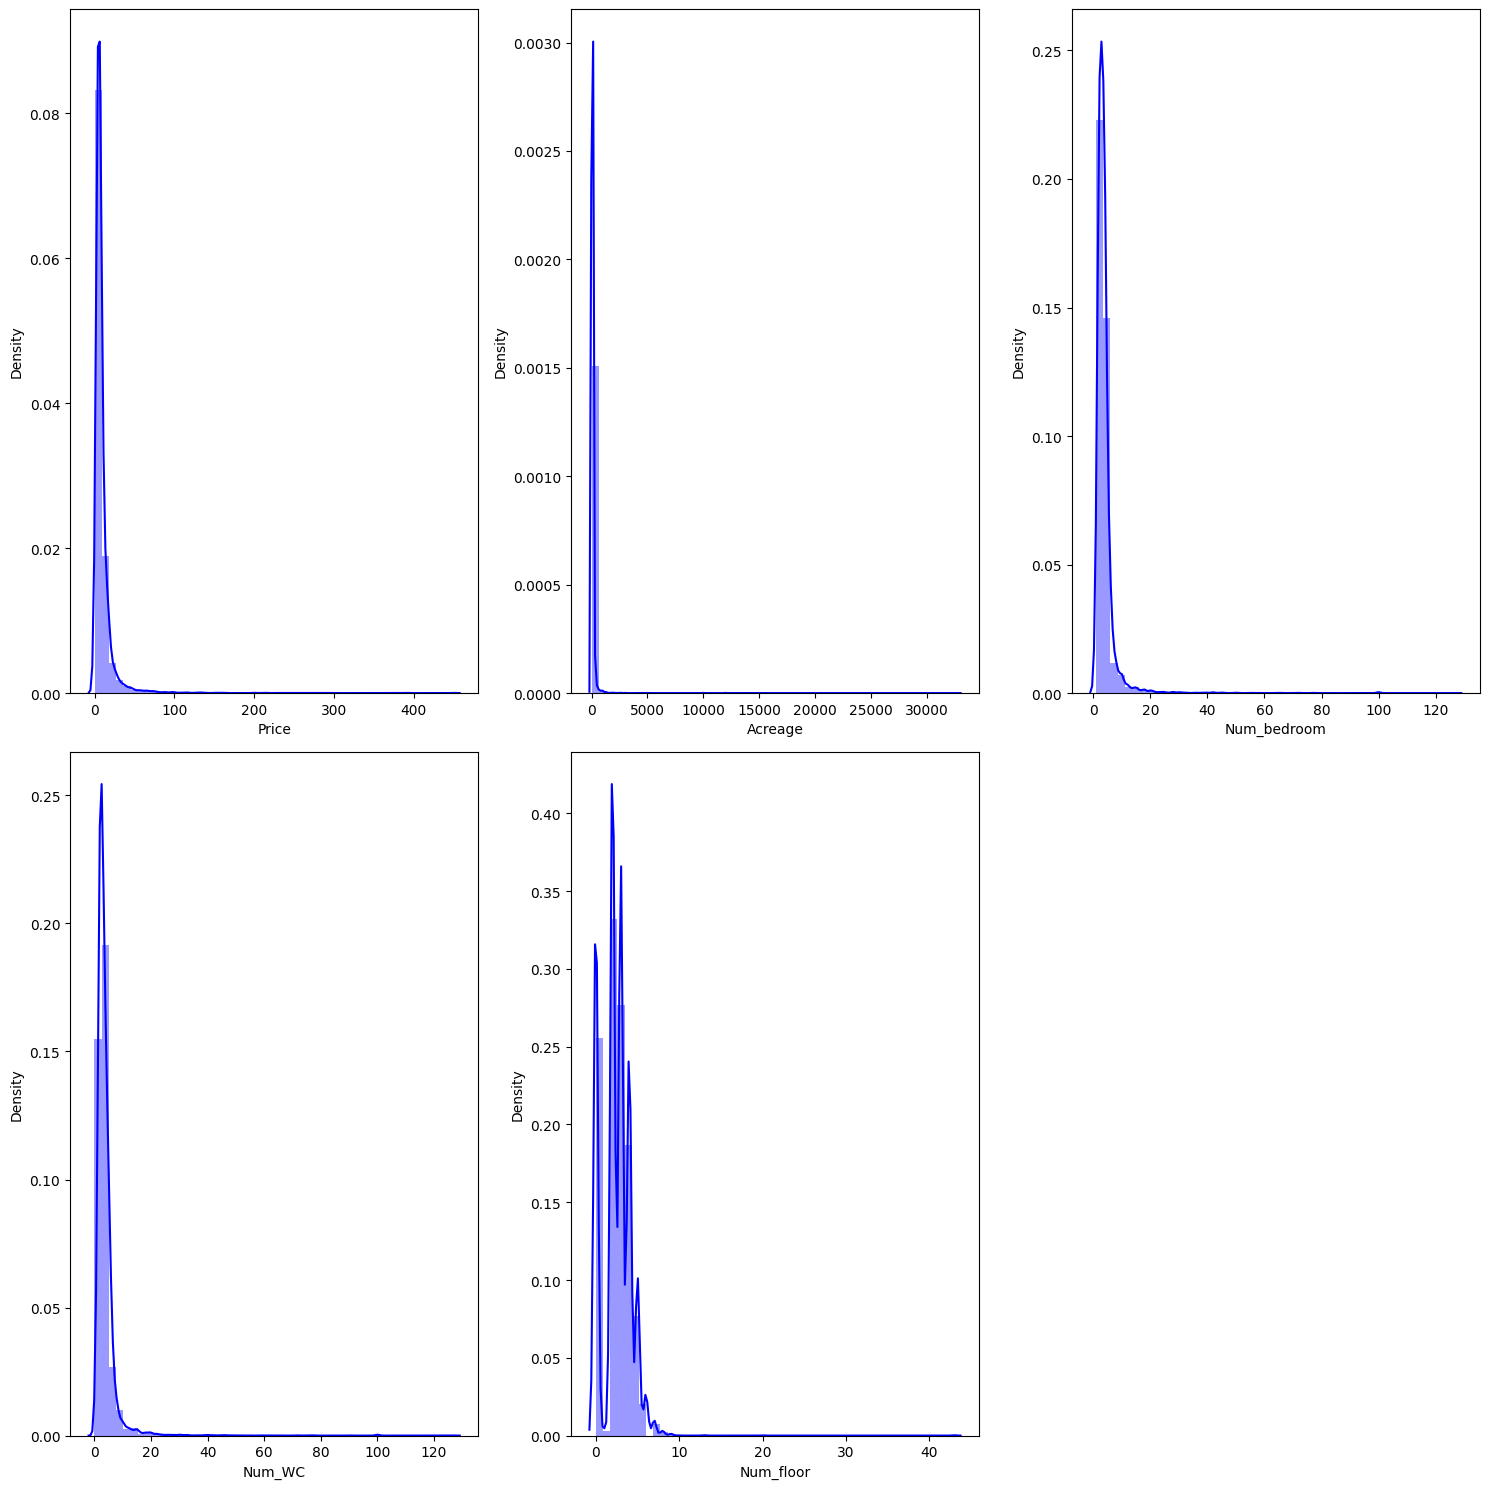

In [10]:
def visualize_histogram(cont_var, df):
    if len(cont_var)%3 == 0:
        n = len(cont_var)/3
    else:
        n = len(cont_var)//3 + 1
    plt.figure(figsize=(15,15))
    for i in range(1,len(cont_var)+1):
        plt.subplot(n,3,i)
        sns.distplot(df[cont_var[i-1]].dropna(), color = 'Blue')
    plt.tight_layout()
    plt.show()

visualize_histogram(num_vars, df)

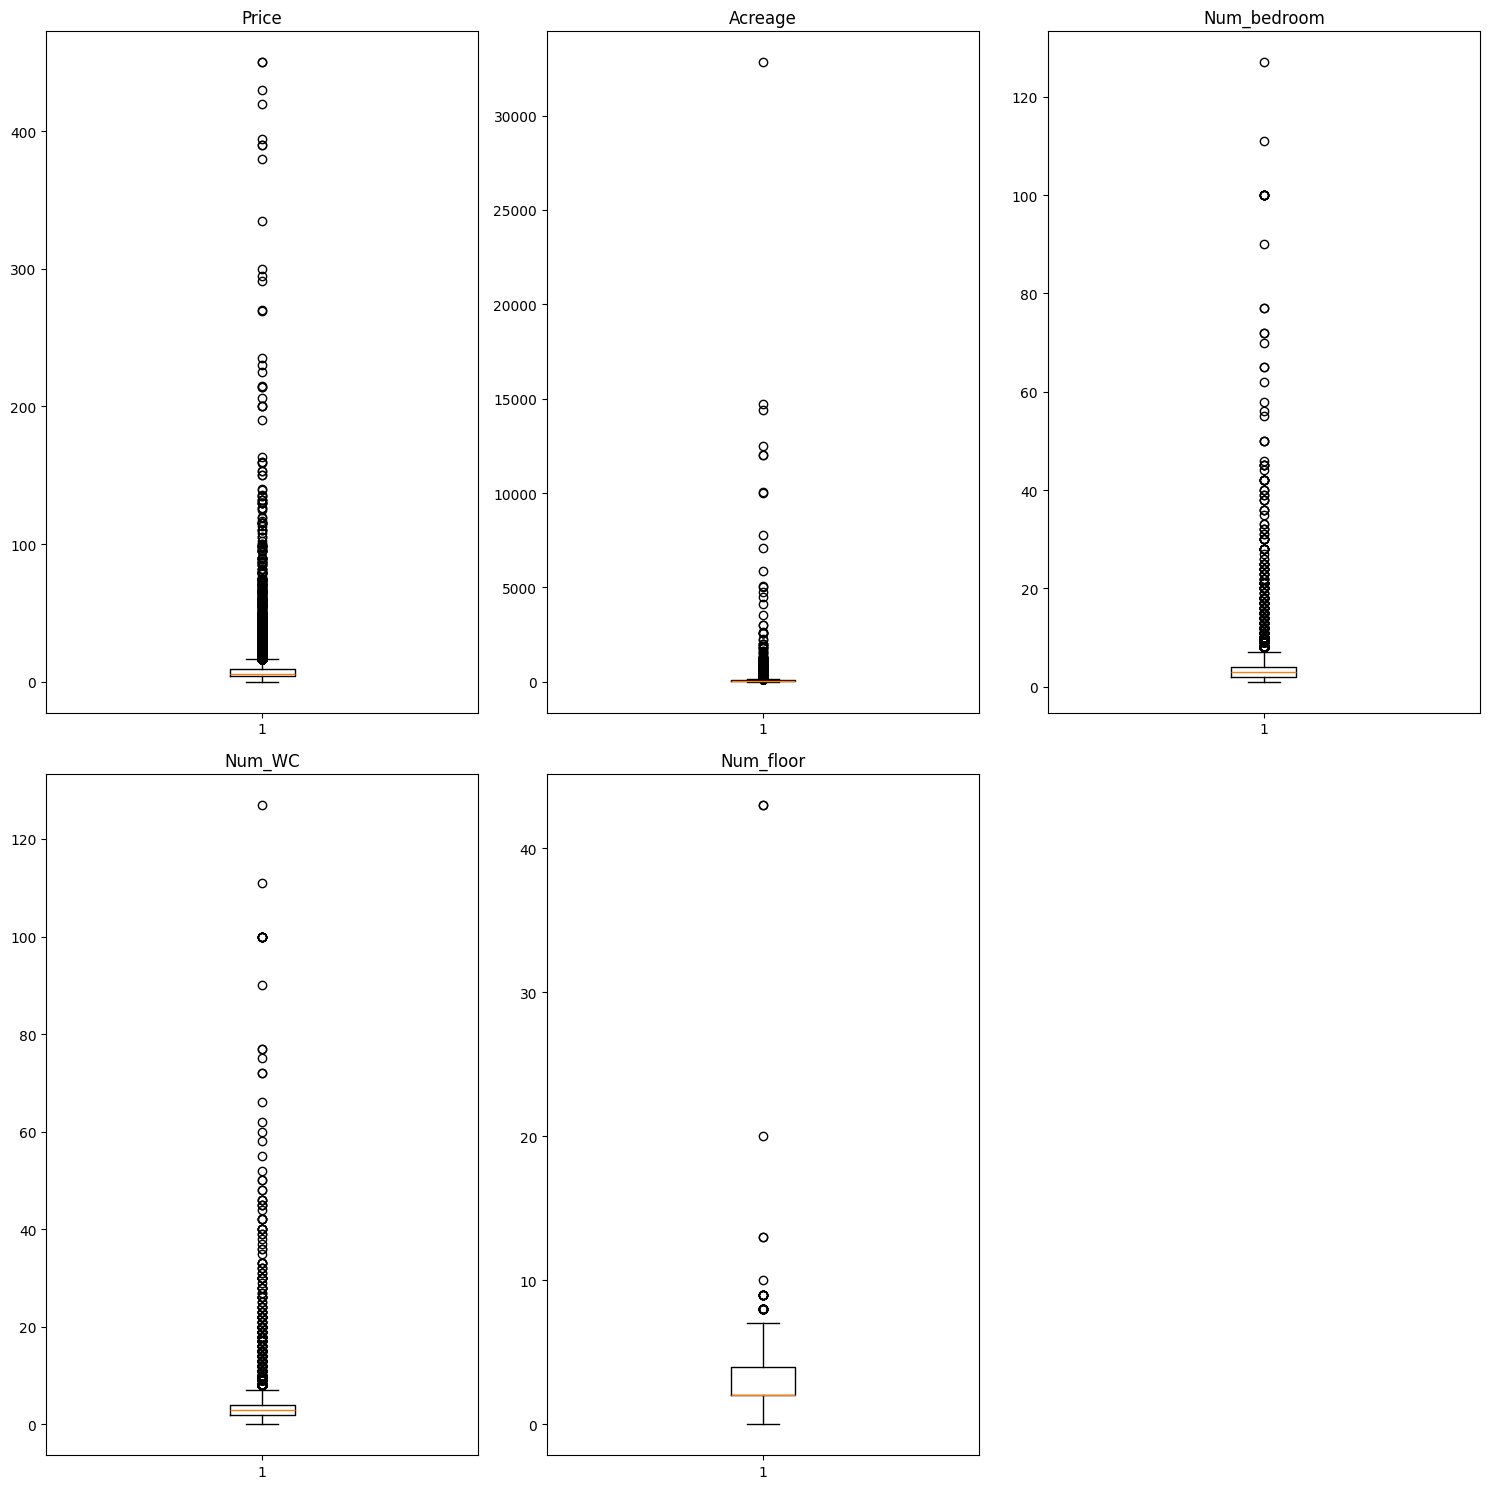

In [11]:
def visualize_boxplot(cont_var, df):
    if len(cont_var)%3 == 0:
        n = len(cont_var)/3
    else:
        n = len(cont_var)//3 + 1
    plt.figure(figsize=(15,15))
    for i in range (1,len(cont_var)+1):
        plt.subplot(n,3,i)
        plt.boxplot(df[cont_var[i-1]].dropna())
        plt.title(cont_var[i-1])
    plt.tight_layout()
    plt.show()

visualize_boxplot(num_vars, df)

Axes(0.125,0.11;0.775x0.77)


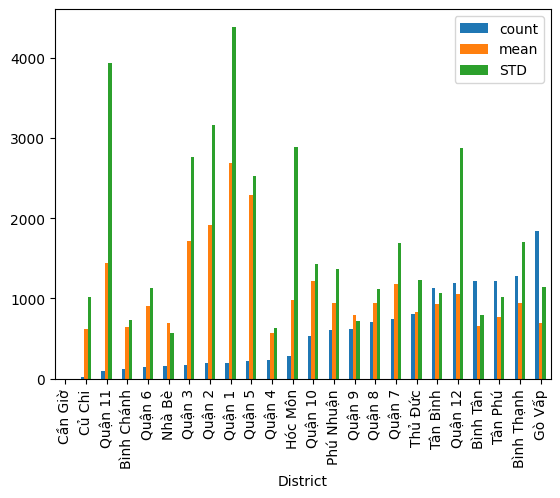

In [12]:
count=df.groupby('District').size().rename('count')
mean= df.groupby('District').mean()['Price'].rename('mean')*100
var = df.groupby('District').std()['Price'].rename('STD')*100

# des =pd.merge(pd.merge(count,mean,on='locate'),var,on='locate')

des=pd.concat([count, mean,var], axis=1)
des=des.sort_values(by='count')
print(des.plot(kind="bar"))

Data has a lot of outliers, so we have to remove it for further analysis.

### Removing Outliers

In [13]:
import scipy

def drop_outliers(num_vars, df):
    for num_var in num_vars:
        upper_limit= np.quantile(df[num_var],0.75) + 1.5*scipy.stats.iqr(df[num_var])
        lower_limit= np.quantile(df[num_var],0.25) - 1.5*scipy.stats.iqr(df[num_var])
        df = df[ (df[num_var]>=lower_limit) & (df[num_var]<=upper_limit)]
    return df

df = drop_outliers(num_vars, df).reset_index(drop=True)

### Visualization After Removing Outliers

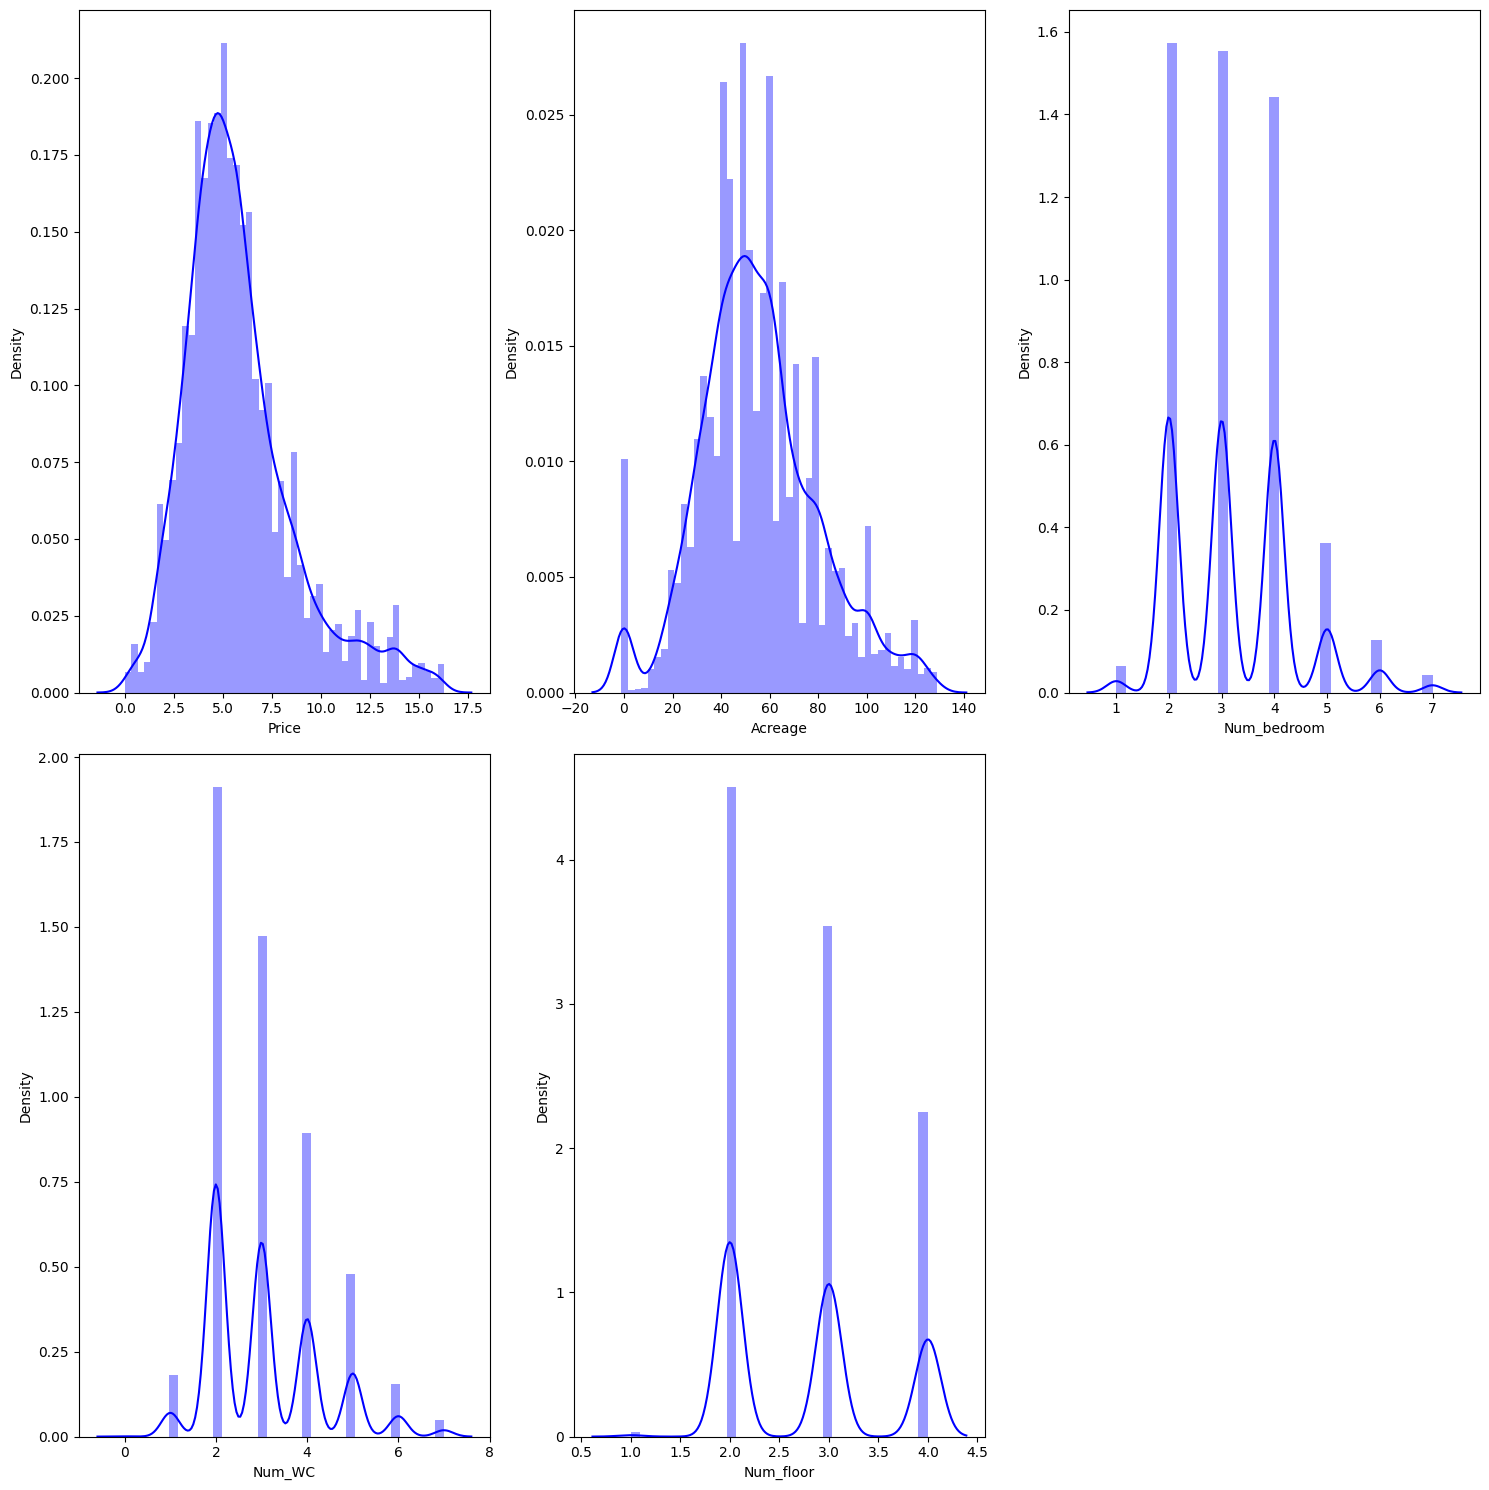

In [14]:
def visualize_histogram(cont_var, df):
    if len(cont_var)%3 == 0:
        n = len(cont_var)/3
    else:
        n = len(cont_var)//3 + 1
    plt.figure(figsize=(15,15))
    for i in range(1,len(cont_var)+1):
        plt.subplot(n,3,i)
        sns.distplot(df[cont_var[i-1]].dropna(), color = 'Blue')
    plt.tight_layout()
    plt.show()

visualize_histogram(num_vars, df)

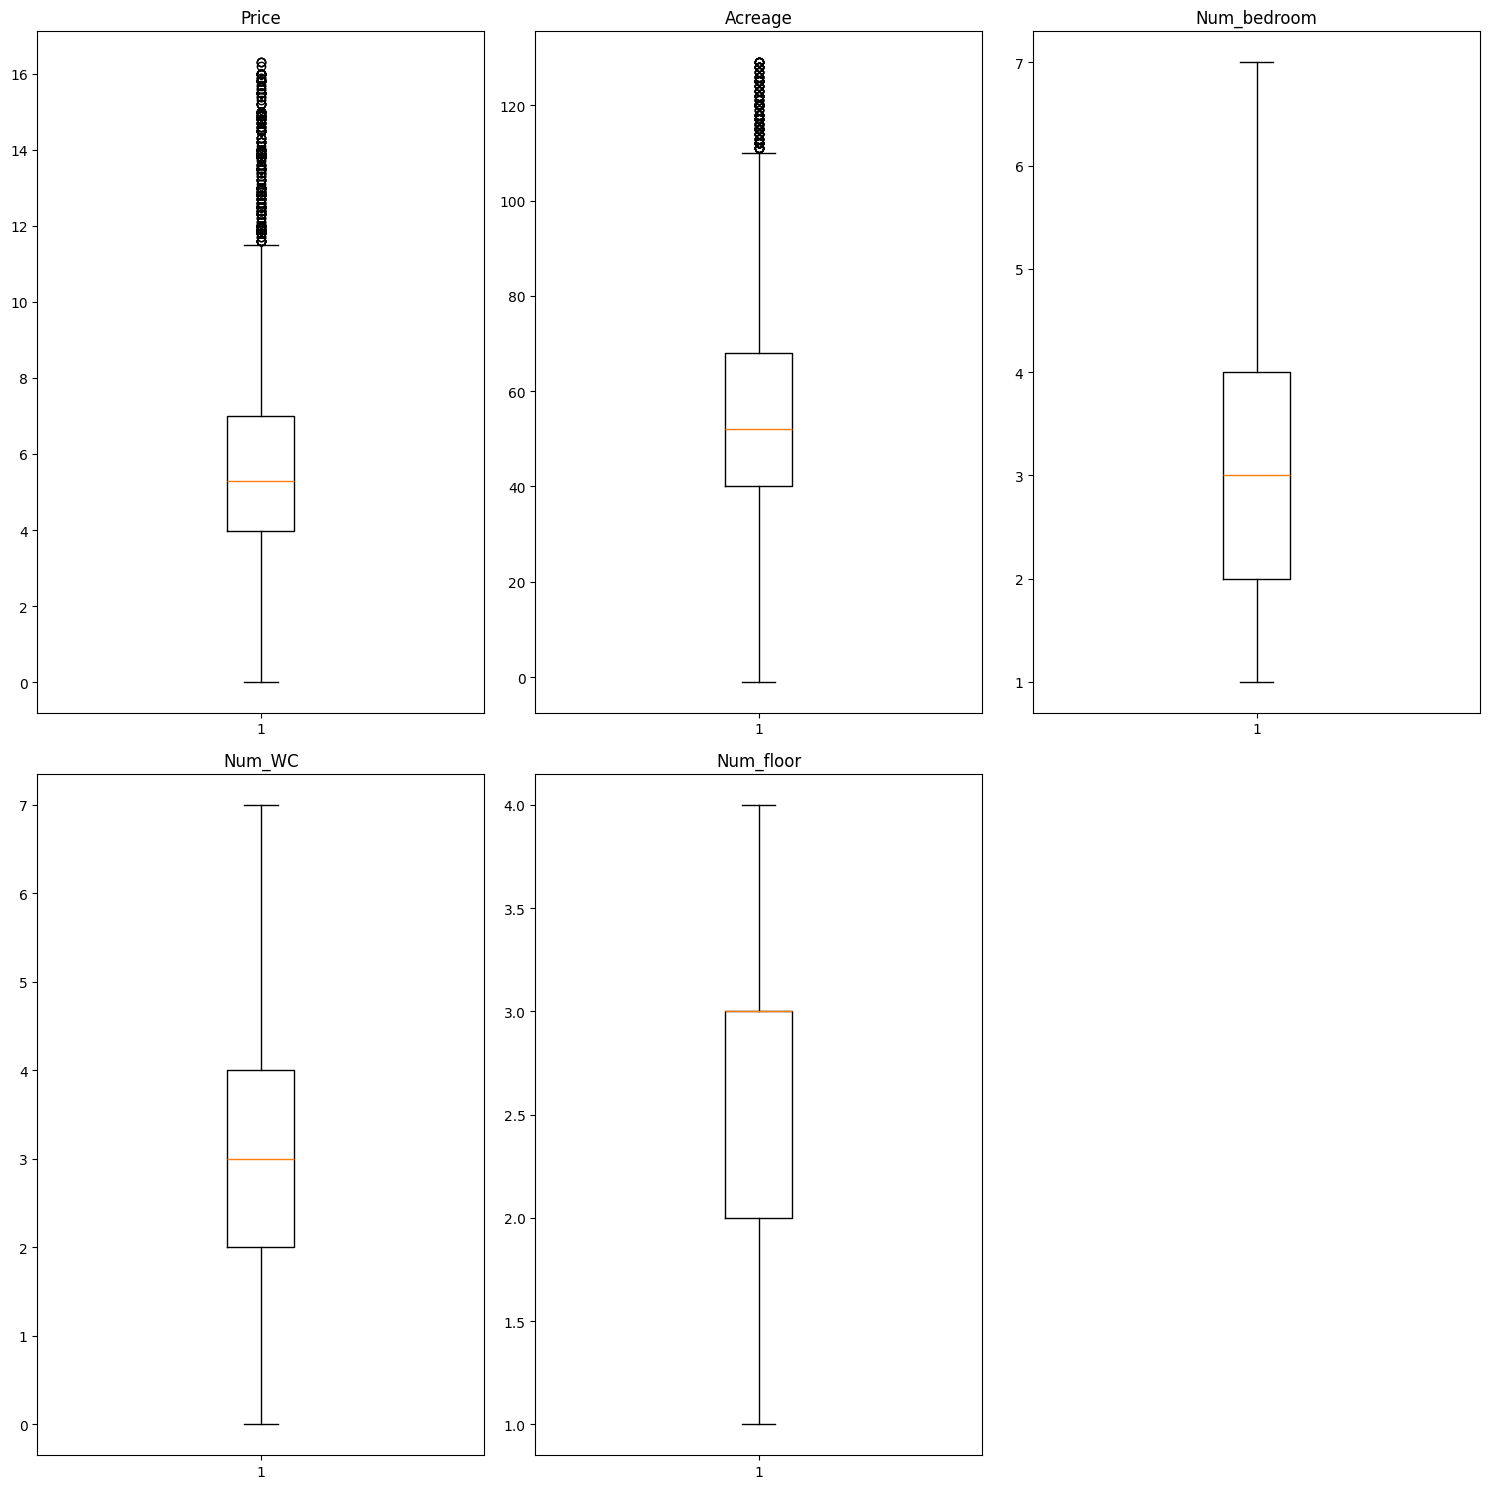

In [15]:
def visualize_boxplot(cont_var, df):
    if len(cont_var)%3 == 0:
        n = len(cont_var)/3
    else:
        n = len(cont_var)//3 + 1
    plt.figure(figsize=(15,15))
    for i in range (1,len(cont_var)+1):
        plt.subplot(n,3,i)
        plt.boxplot(df[cont_var[i-1]].dropna())
        plt.title(cont_var[i-1])
    plt.tight_layout()
    plt.show()

visualize_boxplot(num_vars, df)

Axes(0.125,0.11;0.775x0.77)


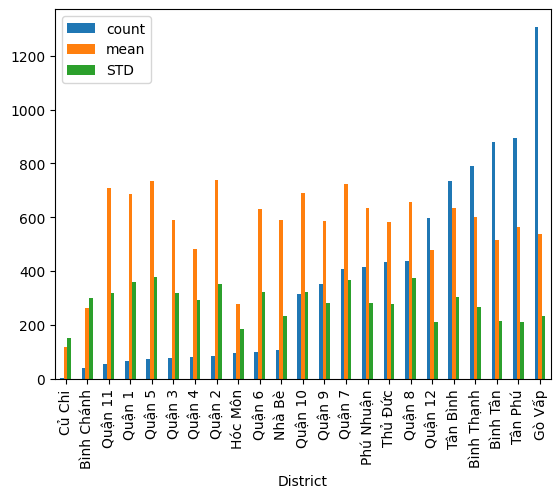

In [16]:
count=df.groupby('District').size().rename('count')
mean= df.groupby('District').mean()['Price'].rename('mean')*100
var = df.groupby('District').std()['Price'].rename('STD')*100

# des =pd.merge(pd.merge(count,mean,on='locate'),var,on='locate')

des=pd.concat([count, mean,var], axis=1)
des=des.sort_values(by='count')
print(des.plot(kind="bar"))

### Bivariate Analysis

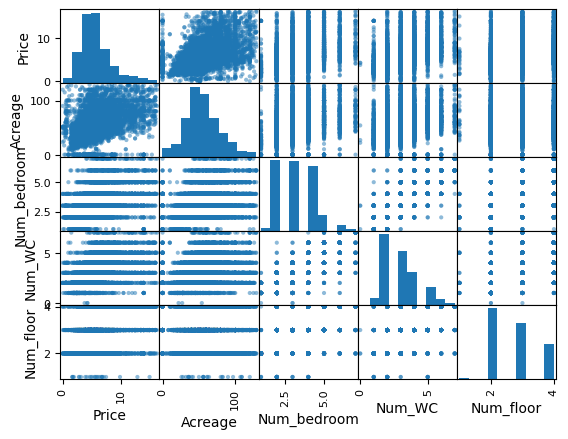

In [17]:
from pandas.plotting import scatter_matrix

scatter_matrix(df[num_vars])
plt.show()

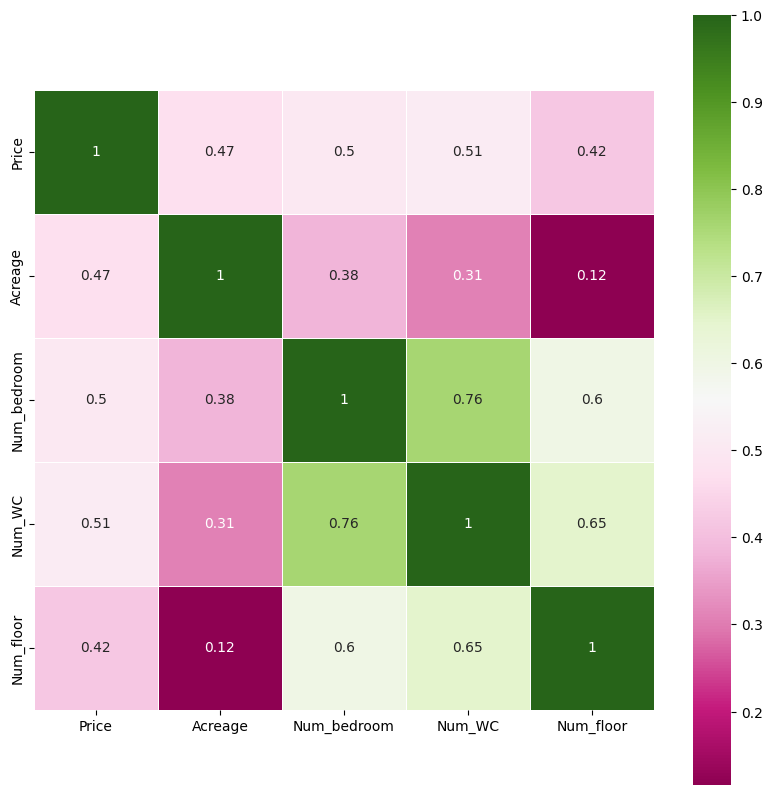

In [18]:
def visualize_heatmap(cont_var, df):
    plt.figure(figsize=(10,10))
    sns.heatmap(df[cont_var].corr(), cmap="PiYG", annot=True,square=True, linewidths=.5)
    plt.show()

visualize_heatmap(num_vars, df)

Seems like num_bedroom and num_WC connected to each other. So we may want to remove one of them when modeling.

### PCA

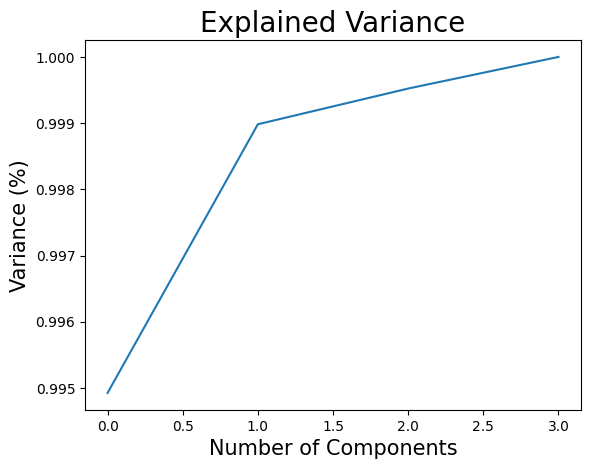

In [19]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

pca_vars = ["Acreage", "Num_bedroom","Num_WC","Num_floor"]
df_pca = df[pca_vars]
scaler=MinMaxScaler()
scaled_data = scaler.fit_transform(df_pca)
pca = PCA().fit(df_pca)

plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))

plt.xlabel('Number of Components', fontsize = 15)
plt.ylabel('Variance (%)', fontsize = 15)
plt.title('Explained Variance', fontsize = 20)

plt.show()

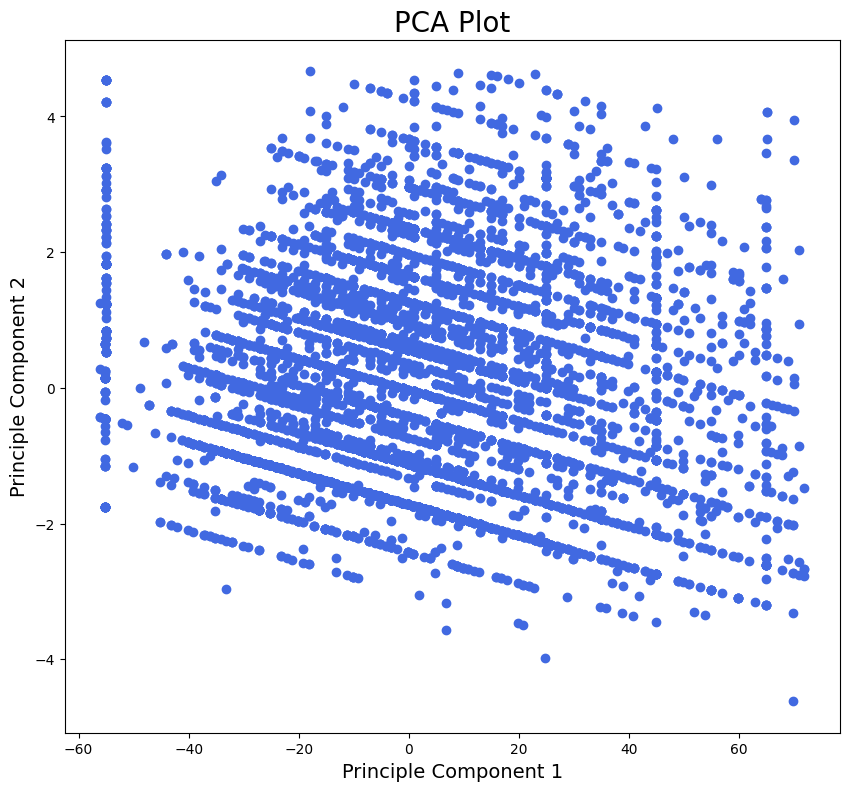

In [20]:
pca = PCA(n_components=2).fit(df_pca)
pca_dataset = pca.transform(df_pca)

pca_dataset= pd.DataFrame(data = pca_dataset, index = df_pca.index)

z_scores = np.abs((pca_dataset - pca_dataset.mean()) / pca_dataset.std())
outlier_threshold = 3
outliers = np.where(z_scores > outlier_threshold)
cleaned_dataset = pca_dataset.drop(outliers[0])

pca_result = pca.fit_transform(cleaned_dataset)

fig = plt.figure(figsize=(10, 9))
ax = fig.add_subplot(1, 1, 1)

x = pca_result[:, 0]
y = pca_result[:, 1]

ax.scatter(x, y, c='royalblue', marker='o')

ax.set_title('PCA Plot', fontdict={'fontsize': 20})
ax.set_xlabel('Principle Component 1', fontdict={'fontsize': 14})
ax.set_ylabel('Principle Component 2', fontdict={'fontsize': 14})

plt.show()

In [21]:
pd.set_option('display.expand_frame_repr', False)

def print_dataframe(data):
    cov = np.cov(data.T)
    eigvals, eigvecs = np.linalg.eig(cov)

    idx = np.argsort(eigvals)[::-1]
    eigvecs = abs(eigvecs[:, idx])
    df = pd.DataFrame(eigvecs.T[:2], columns=data.columns)
    print(df)

data = print_dataframe(df_pca)
data

    Acreage  Num_bedroom    Num_WC  Num_floor
0  0.999722     0.017412  0.015425   0.003778
1  0.022659     0.592520  0.704049   0.390796


## **4.Train and Testing Models**

In [22]:
one_hot = pd.get_dummies(df['District'])
one_hot = one_hot.astype(int)
df = pd.concat([df, one_hot], axis = 1)
df.drop('District', axis = 1, inplace  = True)
df = df.reset_index(drop = True)

df

,Price,Acreage,Num_floor,Num_bedroom,Num_WC,Bình Chánh,Bình Thạnh,Bình Tân,Củ Chi,Gò Vấp,...,Quận 3,Quận 4,Quận 5,Quận 6,Quận 7,Quận 8,Quận 9,Thủ Đức,Tân Bình,Tân Phú
0,4.85,45.0,2.0,3.0,3.0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,4.70,85.0,2.0,3.0,2.0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,5.80,83.0,4.0,5.0,5.0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,6.90,0.0,4.0,5.0,4.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3.80,39.0,3.0,4.0,3.0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8334,4.50,56.0,3.0,4.0,3.0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8335,5.70,33.0,3.0,3.0,2.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
8336,3.30,25.0,2.0,2.0,2.0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
8337,8.00,105.0,3.0,4.0,4.0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


### Feature Scaling

In [23]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaling_df = df
scaling_df = scaling_df.reset_index(drop = True)
scaling_df[["Acreage","Num_floor","Num_bedroom"]] = scaler.fit_transform(scaling_df[["Acreage","Num_floor","Num_bedroom"]])

In [24]:
scaling_df = scaling_df.drop(["Num_WC"],axis = 1)
scaling_df

,Price,Acreage,Num_floor,Num_bedroom,Bình Chánh,Bình Thạnh,Bình Tân,Củ Chi,Gò Vấp,Hóc Môn,...,Quận 3,Quận 4,Quận 5,Quận 6,Quận 7,Quận 8,Quận 9,Thủ Đức,Tân Bình,Tân Phú
0,4.85,-0.422192,-0.987826,-0.176416,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,4.70,1.228434,-0.987826,-0.176416,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,5.80,1.145903,1.559323,1.629760,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,6.90,-2.279146,1.559323,1.629760,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3.80,-0.669786,0.285749,0.726672,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8334,4.50,0.031730,0.285749,0.726672,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8335,5.70,-0.917380,0.285749,-0.176416,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
8336,3.30,-1.247505,-0.987826,-1.079504,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
8337,8.00,2.053747,0.285749,0.726672,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


### Splitting Data

Splitting into predictors and targets.

In [25]:
y = scaling_df["Price"]
x = scaling_df.drop("Price", axis = 1)

Split data into 3 sets: training set (for model training), validation set (for choosing model that has the best performance), and test set.

In [26]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2, random_state= 42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size = 0.4, random_state= 42)

Text(0.5, 1.0, 'y_test')

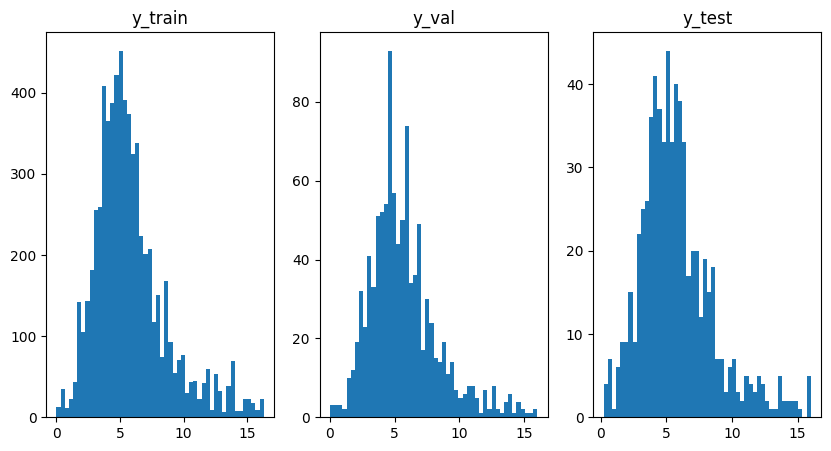

In [27]:
# distribution
fig, axs = plt.subplots(1, 3, figsize = (10, 5))
# Plot
axs[0].hist(y_train, bins= 50 )
axs[1].hist(y_val, bins= 50)
axs[2].hist(y_test, bins=50)
#Title
axs[0].set_title('y_train')
axs[1].set_title('y_val')
axs[2].set_title('y_test')

Metrics used: R2 score (r2), mean absolute percentage error (mape), mean absolute error (mse) where
<br> $$mape =  1 - \frac{1}{n} \sum(\frac{|true - predicted|}{true})$$


### Linear Regression

In [28]:
from sklearn.linear_model import LinearRegression

linear = LinearRegression()
linear.fit(x_train, y_train)

LinearRegression()

In [29]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error

y_pred_val = linear.predict(x_val)
r2 = r2_score(y_val, y_pred_val)
mape = mean_absolute_percentage_error(y_val, y_pred_val)
mse = mean_squared_error(y_val, y_pred_val)
linear_result = ["Linear regression", r2, 100 -100*mape, mse]

### Ridge regression

- The main idea behind Ridge is to avoid the overfitting problem.
- predictions made with ridge regression is less **sensitive** to weights than linear regression.
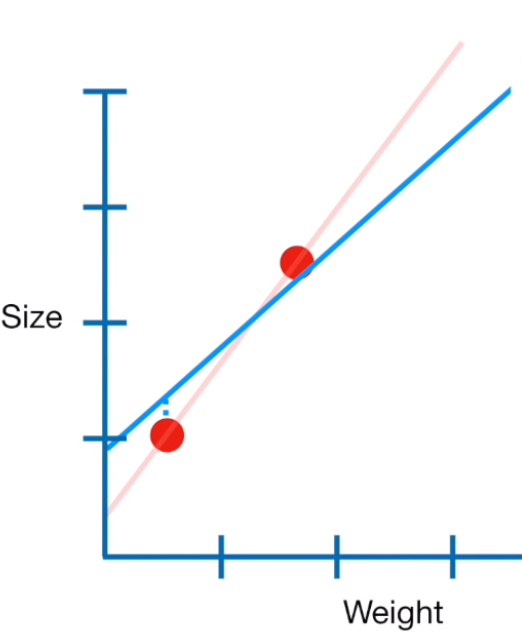

-Ridge regression has hyperparameter $\alpha$. <br> i.e $\text{minimize } L(w) = \frac{1}{2}\sum(y_i-w^Tx)^2+\alpha||w||^2 $ which can be tuned by using grid search cross validation method.
<br>- Grid search CV is used to train a machine learning model with multiple combinations of training hyper parameters and finds the best combination of parameters which optimizes the evaluation metric. It creates an exhaustive set of hyperparameter combinations and train model on each combination. Default number of folds is 5.
<br> It means that for each combination, we fit 5 folds, average them and choosing the best score among them.



In [30]:
from sklearn.model_selection import GridSearchCV
#ridge
from sklearn.linear_model import Ridge
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0,
                    10.0, 20, 50, 100, 500, 1000 ]}
ridge = Ridge()
grid_cv_ridge = GridSearchCV(estimator=ridge,
                       param_grid=params,
                       scoring='neg_mean_squared_error',
                       return_train_score=True,
                       verbose=1)

# fiting GridSearchCV() with X_train and y_train
grid_cv_ridge.fit(x_train,y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [31]:
best_grid_ridge = grid_cv_ridge.best_estimator_

In [32]:
y_pred_val = best_grid_ridge.predict(x_val)
r2 = r2_score(y_val, y_pred_val)
mape = mean_absolute_percentage_error(y_val, y_pred_val)
mse = mean_squared_error(y_val, y_pred_val)
ridge_result = ["Ridge regression (Tuned)", r2, 100 -100*mape, mse]

### Lasso regression

 - Similar to ridge, hyperparameter $\alpha$.  i.e $\text{minimize } L(w) = \frac{1}{2}\sum(y_i-w^Tx_i)^2+\alpha||w|| $  is tuned using GridSearchCV.
<br> A small difference between Lasso and Ridge is that in Lasso, the slope can be shrink to 0, i.e the useless variable can be excluded.
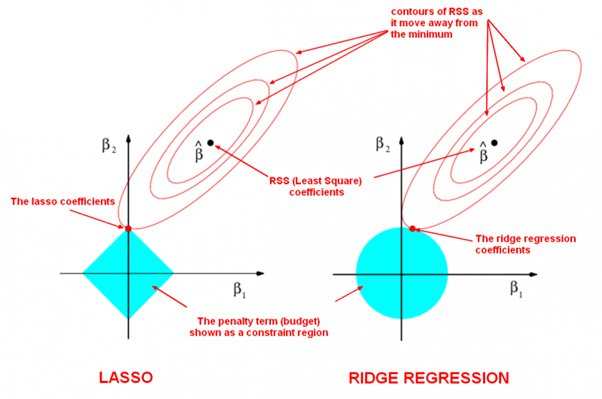

In [33]:
from sklearn.linear_model import Lasso
# Initialising Lasso()
lasso = Lasso()

#usig same attributes used for Ridge tuning except estimator here would be lasso
grid_cv_lasso = GridSearchCV(estimator=lasso,
                       param_grid=params,
                       scoring='neg_mean_squared_error',
                       return_train_score=True,
                       verbose=1)
#fiting model_cv
grid_cv_lasso.fit(x_train,y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [34]:
best_grid_lasso = grid_cv_lasso.best_estimator_

In [35]:
y_pred_val = best_grid_lasso.predict(x_val)
r2 = r2_score(y_val, y_pred_val)
mape = mean_absolute_percentage_error(y_val, y_pred_val)
mse = mean_squared_error(y_val, y_pred_val)
lasso_result = ["Lasso regression (Tuned)", r2, 100 -100*mape, mse]

### Random Forest

Random Forest use a variety of decision trees and processing them parallely to increase the effectiveness.
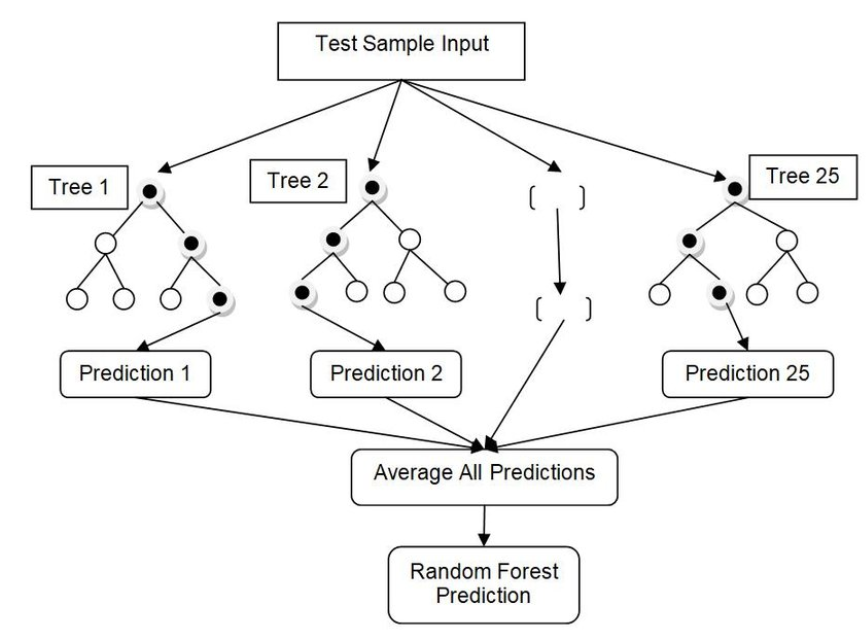
Here tune these parameter:
<br> - n_estimators = number of trees in the foreset.
<br> - max_features = max number of features considered for splitting a node.
<br> - max_depth = max number of levels in each decision tree.
<br> - min_samples_split = min number of data points placed in a node before the node is split.
<br>- min_samples_leaf = min number of data points allowed in a leaf node.
<br> - bootstrap = method for sampling data points (with or without replacement).

In [36]:
from sklearn.ensemble import RandomForestRegressor

In [37]:
#Random Forest
rf = RandomForestRegressor()
rf.fit(x_train, y_train)

RandomForestRegressor()

In [38]:
y_pred_val = rf.predict(x_val)
r2 = r2_score(y_val, y_pred_val)
mape = mean_absolute_percentage_error(y_val, y_pred_val)
mse = mean_squared_error(y_val, y_pred_val)
rf_result = ["Random Forest", r2, 100 -100*mape, mse]

In [39]:
#tuning Random forest
param_grid = {
    'bootstrap': [True , False],
    'max_depth': [8, 9, None],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 500, 1000, 2000]
}

# Instantiate the grid search model
grid_cv_rf = GridSearchCV(estimator = rf, param_grid = param_grid,
                          cv = 3, n_jobs = -1, verbose = 2)
grid_cv_rf.fit(x_train, y_train)

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [8, 9, None],
                         'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [100, 500, 1000, 2000]},
             verbose=2)

In [40]:
best_grid_rf = grid_cv_rf.best_estimator_

In [41]:
y_pred_val = best_grid_rf.predict(x_val)
r2 = r2_score(y_val, y_pred_val)
mape = mean_absolute_percentage_error(y_val, y_pred_val)
mse = mean_squared_error(y_val, y_pred_val)
best_grid_rf_result = ["Random Forest (Tuned)", r2, 100 -100*mape, mse]

### Support Vector

Unlike Support Vector Machines (SVMs) used for classification tasks,SVR seeks to find a hyperplane that best fits the data points in a continuous space. This is achieved by mapping the input variables to a high-dimensional feature space and finding the hyperplane that maximizes the margin (distance) between the hyperplane and the closest data points, while also minimizing the prediction error.
Formal:
$$min (\frac{1}{2}||w||^2 + C\sum\epsilon_i)$$ $$s.t\text{ }||y_i-w^Tx_i|
|\leq\epsilon_i+ \epsilon , \epsilon_i \geq 0 $$
<br> $ϵ$ is tolerance, $\epsilon_i$ is error <br>
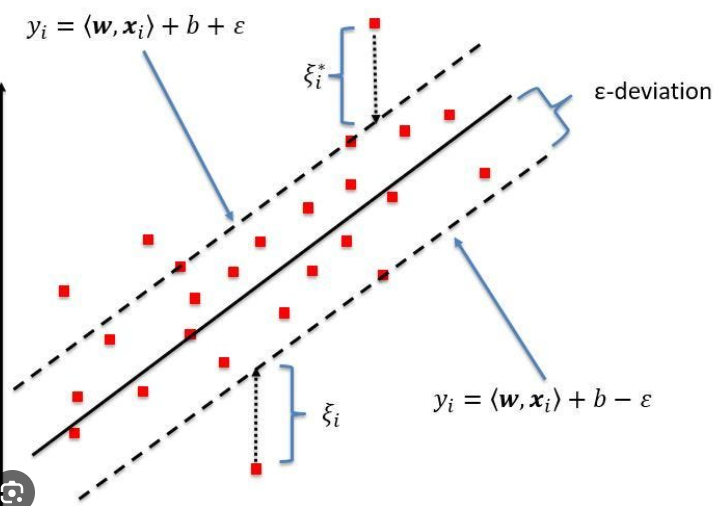

In [42]:
## SV
from sklearn.svm import SVR
svr = SVR()
svr.fit(x_train, y_train)

SVR()

In [43]:
y_pred_val = svr.predict(x_val)
r2 = r2_score(y_val, y_pred_val)
mape = mean_absolute_percentage_error(y_val, y_pred_val)
mse = mean_squared_error(y_val, y_pred_val)
svr_result = ["Support Vector", r2, 100 -100*mape, mse]

In [44]:
# tune
params = {'kernel': ('rbf','linear','poly'),
              'C':[1.5, 10],
              'gamma': [1e-7, 1e-4],
              'epsilon':[0.1,0.3]}
grid_cv_svr = GridSearchCV(estimator = svr, param_grid = params)
grid_cv_svr.fit(x_train,y_train)

GridSearchCV(estimator=SVR(),
             param_grid={'C': [1.5, 10], 'epsilon': [0.1, 0.3],
                         'gamma': [1e-07, 0.0001],
                         'kernel': ('rbf', 'linear', 'poly')})

In [45]:
best_grid_svr = grid_cv_svr.best_estimator_

In [46]:
y_pred_val = best_grid_svr.predict(x_val)
r2 = r2_score(y_val, y_pred_val)
mape = mean_absolute_percentage_error(y_val, y_pred_val)
mse = mean_squared_error(y_val, y_pred_val)
best_grid_svr_result = ["Support Vector (Tuned)", r2, 100 -100*mape, mse]

### XGBoost

 - XGBoost belongs to Gradient Boosting algorithms
<br>
 - The main ideas of GradientBoost:
<br> - First, make a prediction (can use average of all output, thats $\hat{Y_1} = \frac{1}{n}\sum Y$ ), the residual between this prediction and the true value is large $r_1 = Y - \hat{Y_1}$, so we take small steps to decrease the residual (pseudo_residuals):
<br> - Use first pseudo-residual as the target, fit a tree on this target and predict first residuals, call it $\hat{r_1}$
<br> - Then make a new prediction $\hat{Y_2} = \hat{Y_1} + \alpha \hat{r_1}, α \in (0,1)$, then calculate second pseudo-residual as $r_2 = Y - \hat{Y_2} $, the prediction is better and pseudo-residuals decreases
<br> - Then use second pseudo_residuals as the target and fit a tree on it, do this until the pseudo-residuals could not be smaller.
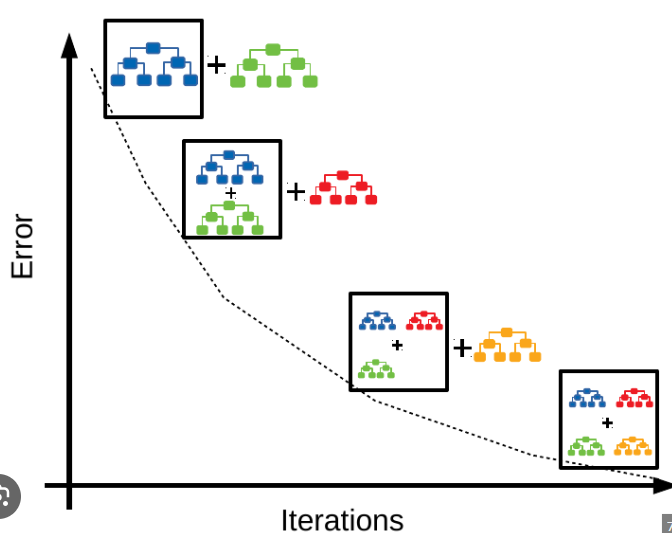







-XGBoost is one of the fastest implementations of gradient boosting trees.
<br>- It does this by tackling one of the **major inefficiencies** of gradient boosting trees: considering the potential loss for all possible splits to create a new branch (especially if you consider the case where there are thousands of features, and therefore thousands of possible splits). XGBoost tackles this inefficiency by looking at the distribution of features across all data points in a leaf and using this information to reduce the search space of possible feature splits.

In [47]:
#Xgboost
import xgboost as xgb

xgbr = xgb.XGBRegressor(objective='reg:squarederror')
xgbr.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [48]:
y_pred_val = xgbr.predict(x_val)
r2 = r2_score(y_val, y_pred_val)
mape = mean_absolute_percentage_error(y_val, y_pred_val)
mse = mean_squared_error(y_val, y_pred_val)
xgb_result = ["XGBoost", r2, 100 -100*mape, mse]

In [49]:
from sklearn.model_selection import GridSearchCV
#tune
params = { 'max_depth': [3,4,5,None],
           'learning_rate': [0.05, 0.1, 0.3],
           'n_estimators': [100, 500, 1000, 2000],
           'colsample_bytree': [0.3, 0.7, 1.0]}
xgbr = xgb.XGBRegressor(seed = 20)
grid_cv_xgb = GridSearchCV(estimator=xgbr,
                   param_grid=params,
                   scoring='neg_mean_squared_error',
                   verbose=1)
grid_cv_xgb.fit(x_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bi...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'colsample_bytree': [0.3, 0.7, 1.0],
                         'learning_rate': [0.05, 0.1, 0.3],
                         'max_depth': [3, 4, 5, None],
                         'n_estimators': [100, 500, 1000, 2000]},
             scoring='neg_mean_squared_error', verbose=1)

In [50]:
best_grid_xgb = grid_cv_xgb.best_estimator_

In [51]:
y_pred_val = best_grid_xgb.predict(x_val)
r2 = r2_score(y_val, y_pred_val)
mape = mean_absolute_percentage_error(y_val, y_pred_val)
mse = mean_squared_error(y_val, y_pred_val)
best_grid_xgb_result = ["XGBoost (Tuned)", r2, 100 -100*mape, mse]

### Multilayer Perceptron (MLP)

Use the simple MLP (or fully connected neural networks), because the data provided is small,the task is regression and linear model perform quite well so we only need
small number of layers, lets say 1, and number of neurons in hidden layer is 5.
<br> Briefly:
<br>
- initialize weights.
- input is passed through linear and ReLU activation(element-wise operation) then pass it through a linear activation to output.
- Using Adam optimizer when doing backpropagation.
-Full batch GD.

In [ ]:
## MLP
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
x_train_np, y_train_np = (np.array(x_train), np.array(y_train))
x_val_np, y_val_np = (np.array(x_val), np.array(y_val))

In [ ]:
# As type
y_train_np = np.vstack(y_train_np)
y_val_np = np.vstack(y_val_np)

In [ ]:
x_train_ts = torch.from_numpy(x_train_np).double()
y_train_ts = torch.from_numpy(y_train_np).double()

x_val_ts = torch.from_numpy(x_val_np).double()
y_val_ts = torch.from_numpy(y_val_np).double()

In [ ]:
# Define the input and output dimensions
input_dim = x_train_ts.size()[1]  # number of features
output_dim = 1  # target variable
input_dim, output_dim

In [ ]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        super(MLP, self).__init__()
        self.reg = nn.Sequential (
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )


    def forward(self, x):
        predict = self.reg(x)
        return predict

In [ ]:
# Instantiate the model
model = MLP(input_dim, output_dim, 5).double()
model

In [ ]:
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_each_epoch = []

# Train the model
model.train()
for epoch in range(200):

    outputs = model(x_train_ts)

    loss = criterion(outputs, y_train_ts)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_each_epoch.append(loss.item())
    # Print progress
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/200], Loss: {loss.item():.4f}')


In [ ]:
plt.plot(range(1, len(loss_each_epoch)+1), loss_each_epoch)

In [ ]:
# Test the model
model.eval()
with torch.no_grad():

    outputs = model(x_val_ts)
    test_loss = criterion(outputs, y_val_ts)
    predicted = outputs.numpy()

mlp_result = ["MLP", r2_score(y_val_ts, predicted), (1-mean_absolute_percentage_error(y_val_ts, predicted))*100, test_loss.item()]

### Comparison

In [ ]:
compare = pd.DataFrame([linear_result,ridge_result,lasso_result,rf_result,best_grid_rf_result,svr_result,best_grid_svr_result,xgb_result,best_grid_xgb_result,mlp_result], columns = ["Name", "R2 score", "MAPE score", "MSE score"]).set_index("Name")
compare

$\Longrightarrow$ Seems like XGBoost with HPT is model with best performance so we choose this

### Test Model

In [ ]:
y_pred_test = best_grid_xgb.predict(x_test)
r2 = r2_score(y_test, y_pred_test)
mape = mean_absolute_percentage_error(y_test, y_pred_test)
mse = mean_squared_error(y_test, y_pred_test)

print('R-squared: %.2f' % r2)
print('MAPE: %.2f%%' % (100 - 100 * mape))
print('MSE: %.2f' % mse)

$\Longrightarrow$Model's test accuracy seems like equivalent to validation accuracy

In [ ]:
plt.figure(figsize= (5,5))
plt.scatter(x = y_test, y = y_pred_test, alpha = 0.3)

z = np.polyfit(y_test,y_pred_test,1)
p = np.poly1d(z)
plt.plot(y_test, p(y_test), color = 'red')

plt.ylabel("Predicted Price")
plt.xlabel("Actual Price")

#  **III. References**

1. [Vietnam House Price Prediction by EllieDam](https://github.com/EllieDam/VietNam_HousePrice_prediction)

2. [A Practical Introduction to Web Scraping in Python](https://realpython.com/python-web-scraping-practical-introduction/)

3. [Regression model and Testing in python](https://www.kdnuggets.com/2019/07/check-quality-regression-model-python.html)

4. [Linear, Lasso, and Ridge Regression with scikit-learn](https://www.pluralsight.com/guides/linear-lasso-ridge-regression-scikit-learn)